In [1]:
!pip install plotly

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.stattools import adfuller,kpss
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
from sklearn.linear_model import LinearRegression
from prophet import Prophet 
import graphviz

# GOAL OF THE NOTEBOOK
1. __User specifies a CSV that contains time series data.__ It has 2 columns - `date` and `value`. This could easily be extended/modfied to :
   - collect data from elsewhere or
   - provide an API where this file could be "POSTED" to
2. We can predict the future values of the `value`. The periods we can predict in future is roughly 10%~30% of the current number of observations. This is inferred automatically - though it could be a potential user input. __Look at the TLDR; section at the end for the output__

## Important for us to enquire and find out what is the question we have to answer -
- Is the question `Will the current capacity will last for `x` more days.`
- Then we can approach this in 2 stages:
  - Stage-1 just by projecting the trend - if any - in the time series 
  - Stage-2 doing a real time series forecasting
  - Apologies - the above stages may not make sense if one is not versed with the Time Series Analysis jargons. Suffice it to say, Stage-1 is much simpler than Stage-2. They will yield slightly different values - but it can be explained. Look at the `TLDR` section for a better understanding.


# TODO
1. Tolerate different timegaps between the data points in the time series. For now, it is assumed that we get 1 per day
1. Detect if there is missing data and handle it accordingly
1. Use multiple models (right now, this example uses only ARIMA):
     1. Analyze the raw data (to find out which model may be a better fit for it).
     1. Work out all the Data Prep and pre-Analysis needs for different models - as shown below
     1. Do model error detection  by splitting data into training and test
     1. Select model with least error or model most suited with the data characteristics uncovered.

## Different Models
- ARIMA (SARIMA) Family
- Exponential Smoothing Family (single, double, triple)
- Prophet
- Granite TSFM
- LSTM

_Model accuracy for a particular dataset is to be tested. There is no silver bullet_

|Data Prep and pre-Analysis needs for the models|ARIMA|Exp Smoothing|Prophet|Granite|LSTM|
|---|---|---|---|---|---|
|Does the model need stationary data as input|xxx|xxx|xxx|xxx|xxx|
|Can the model handle missing data|xxx|xxx|xxx|xxx|xxx|
|Can the model handle outliers in data|xxx|xxx|xxx|xxx|xxx|
|Do we need to know if data is trend and seasonality for model tuning|xxx|xxx|xxx|xxx|xxx|
|Do we need to know the type of seasonality in the data for model tuning|xxx|xxx|xxx|xxx|xxx|
|How much data is needed before the model starts forecasting well|xxx|xxx|xxx|xxx|xxx|
|Model metadata|Very mature|Very mature|Created by Facebook - widely used|Lightweight model created by IBM|Neural Net based|


In [3]:
# Step 1: Load your data
# There is a hard coded assumption here - to be removed - that there is one data point per day
# Assuming `data` is your pandas DataFrame with a datetime index

# Pick any one of the data variable by uncommenting only 1 of them
# This data contains Trend and Seasonal Variation
#data = pd.read_csv("sample_time_series.csv", parse_dates=['date'], index_col='date')
# This data is a stationary data set that does NOT have trend and Seasonal Variations
data = pd.read_csv("stationary_time_series.csv", parse_dates=['date'], index_col='date')
# This is the very well known air line passenger data
#data = pd.read_csv("AirPassengers.csv", parse_dates=['date'], index_col='date')
series = data['value']

# diff calculates the time difference between consecutive timestamps (index must be of timestamp datatype)
time_diff = series.index.to_series().diff()
interval = time_diff.mode()[0]
# Get total days
day=interval.days
# Get total hours
hours= interval.seconds // 3600
# Get total seconds
minutes=interval.seconds % 3600 // 60


print("Number of samples in the dataset: ", data.shape[0])
forecast_period = int(data.shape[0] * 0.15)
print("Number of periods being forecast: ", forecast_period)
print("Interval between data points. Day: ", day, " Hours: ", hours, " Minutes: ",minutes)

print(" ")
print("Sample Data")
print("-----------")
print(data.head(3))
print(" ")
print("Sample Stats")
print("------------")
print(data.describe())

Number of samples in the dataset:  100
Number of periods being forecast:  15
Interval between data points. Day:  1  Hours:  0  Minutes:  0
 
Sample Data
-----------
               value
date                
2023-01-01 -0.128596
2023-01-02  1.129574
2023-01-03  0.216327
 
Sample Stats
------------
            value
count  100.000000
mean     0.117967
std      0.995744
min     -2.617335
25%     -0.414557
50%      0.115898
75%      0.654101
max      2.730191


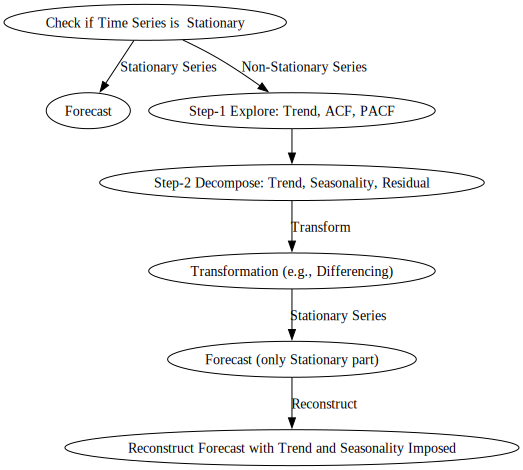

In [4]:
# Explain what is the logic in the code
def draw_decision_tree():
    # Create a Graphviz object for the decision tree
    #dot = graphviz.Digraph(format='png', engine='dot')
    dot = graphviz.Digraph()

    # Define the decision tree steps (Nodes)
    dot.node('A', 'Check if Time Series is  Stationary')
    dot.node('B', 'Forecast')
    dot.node('C', 'Step-1 Explore: Trend, ACF, PACF')
    dot.node('D', 'Step-2 Decompose: Trend, Seasonality, Residual')
    dot.node('E', 'Transformation (e.g., Differencing)')
    dot.node('F', 'Forecast (only Stationary part)')
    dot.node('G', 'Reconstruct Forecast with Trend and Seasonality Imposed')

    # Add edges (decisions leading to next steps)
    dot.edge('A', 'B', label='Stationary Series')
    dot.edge('A', 'C', label='Non-Stationary Series')
    dot.edge('C', 'D', label='')
    dot.edge('D', 'E', label='Transform')
    dot.edge('E', 'F', label='Stationary Series')
    dot.edge('F', 'G', label='Reconstruct')
    
    # Render and view the tree
    #dot.render('decision_tree', view=True)
    return dot

# Call the function to draw the decision tree
explain_logic = draw_decision_tree()
explain_logic


In [5]:
# Step 2: Check for stationarity using the ADF test
def check_stationarity(series):
    adf_result = adfuller(series)
    kpss_result = kpss(series, regression='c')
    
    adf_pvalue = adf_result[1]
    kpss_pvalue = kpss_result[1]
    
    # Stationarity decisions based on p-values
    if adf_pvalue < 0.05 and kpss_pvalue > 0.05:
        print("Time series is stationary. ADF: ", adf_pvalue)
        print("Time series is stationary. ADF: ", kpss_pvalue)
        #return 'Stationary'
        return True
    else:
        print("Time series is Non-stationary. ADF: ", adf_pvalue)
        print("Time series is Non-stationary. ADF: ", kpss_pvalue)
        #return 'Non-Stationary'
        return False

# 2. **Decompose Time Series** (STL Decomposition to automatically detect trend and seasonality)
def decompose_series(series, period=12):
    # Ensure seasonal period is an odd number >= 3
    seasonal_period = period if period >= 3 and period % 2 != 0 else 13  # Default to 13 if not valid
    print("Seasonal Period as input to decompose function:",seasonal_period)
    
    stl = STL(series, seasonal=seasonal_period)
    result = stl.fit()
    
    # Plot the components
    #result.plot()
    #plt.show()

    # Access the components
    #trend_component = result.trend
    #seasonal_component = result.seasonal
    residuals = result.resid

    # Check if residuals are stationary - this is not being used
    # but nevertheless this is an important academic
    # confirmation

    if check_stationarity(residuals.dropna()):
        print("Residuals is stationary")
    else:
        print("Residuals is non-stationary")    
    return result
    
    
# Step 3: Make data stationary if necessary (differencing)
def difference_data(series):
    #first differencing
    diff_series= series.diff().dropna()
    if check_stationarity(diff_series):
        print("Series is now transformed using Differencing to Stationary series successfully")
    else:
        # we have to try other transforms here like log etc!
        print("Waring!!! Series still not stationary after transformed using Differencing")
    return diff_series

# Step 4: Automatically determine the best ARIMA/SARIMA model using pmdarima (auto_arima)
def forecast_arima(series, steps=12):
    
    # Initialize the differenced series
    # to the original series
    diff_series = series.copy() 
    # Check if the data is stationary
    if not check_stationarity(series):
        # Differencing the series to make it stationary
        print(" Doing differencing since data is not stationary ")
        diff_series = difference_data(series)
        #plt.plot(series, label='Diff Series')
        #plt.legend()
        #plt.show()

    # Fit the best ARIMA model
    model = auto_arima(series, seasonal=True, m=12, stepwise=True, trace=True)
    #model = auto_arima(diff_series, seasonal=False, stepwise=True, trace=True)
    print(model.summary())

    # Forecast for the next `steps` periods
    forecast = model.predict(n_periods=steps)
    return forecast,diff_series



def reconstruct_series(forecasted_diff, original_series):

    if check_stationarity(original_series):
        #print("xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx")
        # Create a copy of the original series for reconstruction
        reconstructed = original_series.copy()
        for i in range(len(forecasted_diff)):
            last_value = reconstructed.iloc[-1]  # Get the last value from the original series
            # Add the forecasted difference to the last value
            #forecasted_value = last_value + forecasted_diff.iloc[i]
            forecasted_value = forecasted_diff.iloc[i]
            new_value = forecasted_value
            # Append the new value to the reconstructed series
            #new_index = original_series.index[-1] + pd.DateOffset(months=i+1)
            new_index = original_series.index[-1] + pd.Timedelta(days=i+1)
            reconstructed = pd.concat([reconstructed, pd.Series([new_value], index=[new_index])])
        return reconstructed
    

    
    else:
    
        # Decompose the original series to extract trend and seasonality
        decomposition = decompose_series(original_series)
        trend_component = decomposition.trend
        seasonal_component = decomposition.seasonal
    
       
        #decomposition.plot()
        #plt.title("Decomposition of Time Series in Reconstruction phase")
        #plt.show()
        
        # Create a copy of the original series for reconstruction
        reconstructed = original_series.copy()
    
        # Reconstruct the original series using the forecasted differences
        for i in range(len(forecasted_diff)):
            last_value = reconstructed.iloc[-1]  # Get the last value from the original series
            # Add the forecasted difference to the last value
            forecasted_value = last_value + forecasted_diff.iloc[i]
    
            # Project trend and seasonality into the future
            trend_forecast = trend_component.iloc[-1] + (i+1) * (trend_component.iloc[-1] - trend_component.iloc[-2])  # Simple linear projection
            seasonal_forecast = seasonal_component.iloc[-(12-i) % 12]  # Wrap around seasonality if needed
            
            # Add trend and seasonality to the forecasted differenced value
            new_value = forecasted_value + (trend_forecast - last_value) + seasonal_forecast
            
            # Append the new value to the reconstructed series
            new_index = original_series.index[-1] + pd.Timedelta(days=i+1)
            reconstructed = pd.concat([reconstructed, pd.Series([new_value], index=[new_index])])
        #print("yyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyy")
        return reconstructed

In [6]:
# Function to check for trend
def detect_trend(series, forecast = False , forecast_steps = 12):
    x = np.arange(len(series)).reshape(-1, 1)  # Time index
    #print(x)
    y = series.values
    #print(y)
    model = LinearRegression()
    model.fit(x, y)
    # Get the R-squared value
    r2_value = model.score(x, y)
     
    #print('Coefficients: ', model.coef_)
    #print('Intercepts: ', model.intercept_)   

    # This shows what the model predicts the y values to be 
    # This can be compared with the actual y values in the series to determine the approximation
    y_pred = model.predict(x)

#    if forecast:
#        # Projecting future values
#        # Extend the time index
#        x_future = np.arange(len(series), len(series) + forecast_steps).reshape(-1, 1)
#        # Predicted future values
#        y_future_pred = model.predict(x_future) 
#        # the value we want to forecast
    y_value=0
    x_value = np.zeros((1, 1))    
    if forecast:
        # Projecting future values
        # Extend the time index
        x_future = np.arange(len(series), len(series) + forecast_steps).reshape(-1, 1)
        # Predicted future values
        y_future_pred = model.predict(x_future) 

        # To get the y value for a particular forecast point value
        x_value = x_future[-1,0].reshape(-1, 1)
        y_value = model.predict(x_value)

        #print(f"The predicted/forecasted y value for x (time sequence number) = {x_value[0][0]} is y = {y_value[0]}")
    
    # Plotting the original data and the fitted regression line
    plt.figure(figsize=(20, 6))
    plt.plot(series.index, y, label='Original Data', color='lightblue', marker='o')
    plt.plot(series.index, y_pred, label=f'Regression Line (R² = {r2_value:.2f})', color='red', linestyle='--')
    if forecast:
        # Create future dates based on the frequency of the series
        future_dates = [series.index[-1] + pd.DateOffset(days=i) for i in range(1, forecast_steps + 1)]
        plt.plot(future_dates, y_future_pred, label='Projected Trend', color='green', linestyle='-.')
    if forecast:
        # Create future dates based on the frequency of the series
        if day ==1 :
            #plt.plot(pd.date_range(start=series.index[-1] + pd.Timedelta(days=1), periods=forecast_period, freq='D'), forecast_arima_result, label='ARIMA Forecast')
            future_dates = [series.index[-1] + pd.DateOffset(days=i) for i in range(1, forecast_steps + 1)]
        elif day == 31:
            #plt.plot(pd.date_range(start=series.index[-1] + pd.Timedelta(months=1), periods=forecast_period, freq='M'), forecast_arima_result, label='ARIMA Forecast')
            future_dates = [series.index[-1] + pd.DateOffset(months=i) for i in range(1, forecast_steps + 1)]
            
        plt.plot(future_dates, y_future_pred, label='Projected Trend', color='green', linestyle='-.')      
    plt.axvline(x=series.index[-1], color='black', linestyle='--', label='Last Observed Actual Data Point')
    
    
    plt.title("Trend Detection using Linear Regression")
    plt.xlabel("Time")
    plt.ylabel("Values")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Calculate error metrics
    mae = mean_absolute_error(y, y_pred)  # Mean Absolute Error
    mse = mean_squared_error(y, y_pred)  # Mean Squared Error
    rmse = np.sqrt(mse)  # Root Mean Squared Error

    print(f"R² (R-squared): {r2_value:.2f}")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    if forecast:
        #print(f"The predicted/forecasted y value for x (time sequence number) = {x_value[0][0]} is y = {y_value[0]}")
        print("The predicted/forecast for: ",series.index[-1]," is: ", y_future_pred[0])
    
    # R-squared value is being returned
    return r2_value, mae, mse, rmse



# Detect Trend from STL extracted Trend data and not raw series
# This is more accurate than Regressing from raw data
# because seasonal comps and residuals can distort the real trend.
# Therefore using STL to extract the real trend data and regressing on it
# is better. BTW STL is robust and non-parametric.
def detect_trend_with_stl(series, forecast = False , forecast_steps = 12):
    
    print("Applying STL decomposition...")
    # Decompose the series (to detect trend and seasonality)
    # we actually know 365 is the best fit since we generated data with it
    # we will need to search to find out if the number is 365 or 12 or 7 etc
    decomposition = decompose_series(series,365)
    #decomposition.plot()
    #plt.title("Decomposition of Time Series")
    #plt.show()

    #trend_component = decomposition.trend
    #seasonal_component = decomposition.seasonal

    # Extract trend component
    trend_component = decomposition.trend.dropna()

    # Fit linear regression on the trend component if needed
    X_trend = (trend_component.index - trend_component.index[0]).days.values.reshape(-1, 1)
    y_trend = trend_component.values
    model_trend = LinearRegression()
    model_trend.fit(X_trend, y_trend)
    r2_value_stl = model_trend.score(X_trend, y_trend)
    y_pred = model_trend.predict(X_trend)

    # the value we want to forecast
    y_value=0
    x_value = np.zeros((1, 1))
    if forecast:
        # Projecting future values
        # Extend the time index
        x_future = np.arange(len(series), len(series) + forecast_steps).reshape(-1, 1)
        # Predicted future values
        y_future_pred = model_trend.predict(x_future) 

        # To get the y value for a particular forecast point value
        x_value = x_future[-1,0].reshape(-1, 1)
        y_value = model_trend.predict(x_value)

        #print(f"The predicted/forecasted y value for x (time sequence number) = {x_value[0][0]} is y = {y_value[0]}")

    print("R-Square value from STL trend decompose: ", r2_value_stl)
    plt.figure(figsize=(20, 6))
    plt.plot(series.index, series.values, label='Original Data', color='lightblue', marker='o')
    plt.plot(series.index, y_trend, label='STL extracted Trend Data', color='blue', linestyle='--')
    plt.plot(series.index, y_pred, label=f'Regression Line (R² = {r2_value_stl:.2f})', color='red', linestyle='--')
    if forecast:
        # Create future dates based on the frequency of the series
        if day ==1 :
            #plt.plot(pd.date_range(start=series.index[-1] + pd.Timedelta(days=1), periods=forecast_period, freq='D'), forecast_arima_result, label='ARIMA Forecast')
            future_dates = [series.index[-1] + pd.DateOffset(days=i) for i in range(1, forecast_steps + 1)]
        elif day == 31:
            #plt.plot(pd.date_range(start=series.index[-1] + pd.Timedelta(months=1), periods=forecast_period, freq='M'), forecast_arima_result, label='ARIMA Forecast')
            future_dates = [series.index[-1] + pd.DateOffset(months=i) for i in range(1, forecast_steps + 1)]
            
        #future_dates = [series.index[-1] + pd.DateOffset(days=i) for i in range(1, forecast_steps + 1)]
        plt.plot(future_dates, y_future_pred, label='Projected Trend', color='green', linestyle='-.')
    plt.axvline(x=series.index[-1], color='black', linestyle='--', label='Last Observed Actual Data Point')
    
    
    plt.title("Trend Detection using Linear Regression from STL")
    plt.xlabel("Time")
    plt.ylabel("Values")
    plt.legend()
    plt.grid(True)
    plt.show()
    # Calculate error metrics
    mae = mean_absolute_error(y_trend, y_pred)  # Mean Absolute Error
    mse = mean_squared_error(y_trend, y_pred)  # Mean Squared Error
    rmse = np.sqrt(mse)  # Root Mean Squared Error

    print(f"R² (R-squared): {r2_value_stl:.2f}")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    if forecast:
        print(f"The predicted/forecasted y value for x (time sequence number) = {x_value[0][0]} is y = {y_value[0]}")


    
    # R-squared value is being returned
    return r2_value_stl, mae, mse, rmse

In [7]:
def quantify_high_usage_percentile(series, percentile=80, min_duration=1):

    # diff calculates the time difference between consecutive timestamps (index must be of timestamp datatype)
    time_diff = series.index.to_series().diff()

    # Calculate the most common time difference
    interval = time_diff.mode()[0]

    # Step 1: Calculate the percentile threshold
    threshold = np.percentile(series, percentile)
    #print(f"Threshold for {percentile}th percentile: {threshold}%")
    #print("--------")
    
    # Step 2: Identify periods where CPU usage exceeds the percentile threshold
    high_usage = series[series >= threshold]
    #print(high_usage)
    print("--------")
    
    # Step 3: Find the periods where CPU usage is above the threshold
    above_threshold_periods = []
    current_period_start = None
    
    for i, value in high_usage.items():
        if current_period_start is None:
            current_period_start = i  # Start a new period
            #print("current period: ",i)
        
        # Check if the next value is below the threshold to close the current period
        
        #print("--------")
        #print("last interval in this series: ",high_usage.index[-1])
        next_contg_interval=i + interval
        #print("next contigous interval: ",next_contg_interval)

        # if next interval is greater than the last,quit
        if next_contg_interval <= (high_usage.index[-1] + interval) :
            #print("next high threshold interval: ", high_usage.index[high_usage.index.get_loc(i) + 1])
            #print("--------")
        
            if i == high_usage.index[-1] or (next_contg_interval < high_usage.index[high_usage.index.get_loc(i) + 1]) :
                above_threshold_periods.append((current_period_start, i))  # End the current period
                #print("Threshold Periods closed: ",above_threshold_periods)
                current_period_start = None
    
    # Step 4: Calculate frequency and duration of high usage


    
    num_periods = len(above_threshold_periods)
    
    total_high_usage_time = 0.0
    for start, end in above_threshold_periods:
        # if interval starts and ends at same say, end-start=0, but we need to count the day.
        # therefore we will always add 86400 seconds to account for the day
        total_high_usage_time += 86400 + ((end - start).total_seconds())
    
    avg_high_usage_time = total_high_usage_time / num_periods if num_periods > 0 else 0  # Average period duration in seconds
    
    # Step 5: Identify prolonged periods (optional, e.g., more than 30 minutes)
    prolonged_periods = [period for period in above_threshold_periods if (period[1] - period[0]).total_seconds() >= min_duration * 60]

    max_value = series.max()
    
    # Step 6: Return results
    results = {
        "num_periods where threshold has been exceeded": num_periods,
        "total_high_usage_time_seconds": total_high_usage_time,
        "avg_high_usage_time_seconds": avg_high_usage_time,
        "prolonged_periods_count": len(prolonged_periods),
        "prolonged_periods": prolonged_periods,
        "percentile_set": percentile,
        "metric threshold value": threshold,
        "metric max value": max_value
    }

    for key, value in results.items() :
        if key=="prolonged_periods" :
            for prolonged_period in value :
                print("start period: ",prolonged_period[0]," end period: ",prolonged_period[1]  )
        else :    
            print (key," : ", value)
        
    return results


/var/folders/61/bmwhyqss6rjdhl37b33pbz9m0000gn/T/ipykernel_6522/2435706950.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series, regression='c')
/var/folders/61/bmwhyqss6rjdhl37b33pbz9m0000gn/T/ipykernel_6522/2435706950.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series, regression='c')


Time series is stationary. ADF:  8.314369796996052e-16
Time series is stationary. ADF:  0.1
The series is stationary, no trend or seasonality expected.
Time series is stationary. ADF:  8.314369796996052e-16
Time series is stationary. ADF:  0.1
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.71 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=285.930, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=286.388, Time=0.04 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=286.019, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=285.337, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=284.406, Time=0.04 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=285.155, Time=0.11 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=286.035, Time=0.07 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=284.039, Time=0.03 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=286.023, Time=0.11 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : AIC=287.384, Time=

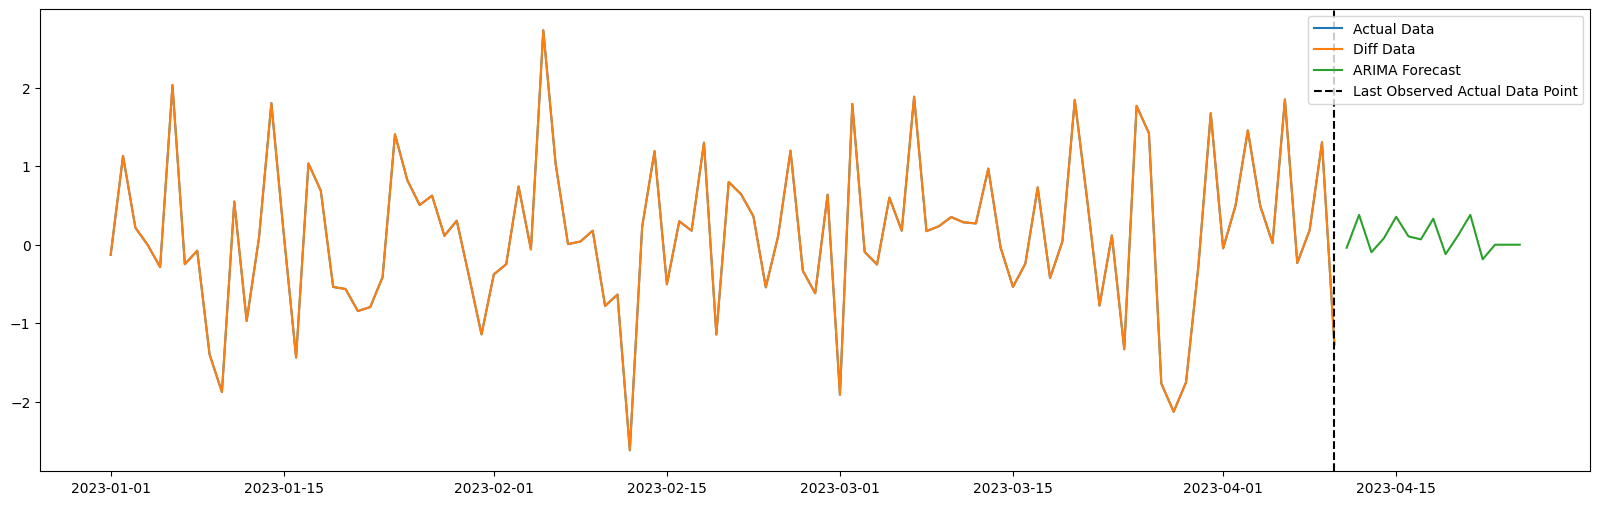

In [8]:
# Main Program
# Assuming `series` is a pandas Series of time series data
#series = data['value']

#print(pd.date_range(start=series.index[-1], periods=12, freq='M'))

# Check for stationarity
if check_stationarity(series):
    print("The series is stationary, no trend or seasonality expected.")
else:
    print("The series is non-stationary. Let us check for trend and seasonality.")
    
    # Check for trend
    r2,_,_,_ = detect_trend_with_stl(series)
    if r2 < 0.05:
        print("No significant trend detected.")
    else:
        print("Trend detected. R-Squared value is: ",r2)



#forecast_arima_result, diff_series = forecast_time_series(series, model_type='ARIMA', steps=forecast_period)
forecast_arima_result, diff_series = forecast_arima(series, steps=forecast_period)
#print("ARIMA Forecast:", forecast_arima_result)
##reconstructed_series = reconstruct_series(forecast_arima_result, series)
#print(type(reconstructed_series))
##print("The predicted/forecast for: ",reconstructed_series.index[-1], " is: ",reconstructed_series.iloc[-1])


# Step 7: Visualize the results (optional)
plt.figure(figsize=(20, 6)) 
plt.plot(series, label='Actual Data')
plt.plot(diff_series, label='Diff Data')
#plt.plot(pd.date_range(start=series.index[-1], periods=12, freq='M'), forecast_arima_result, label='ARIMA Forecast')

if day ==1 :
    plt.plot(pd.date_range(start=series.index[-1] + pd.Timedelta(days=1), periods=forecast_period, freq='D'), forecast_arima_result, label='ARIMA Forecast')
elif day == 31:
    plt.plot(pd.date_range(start=series.index[-1] + pd.Timedelta(days=31), periods=forecast_period, freq='M'), forecast_arima_result, label='ARIMA Forecast')
# Adding a vertical line at the last date of the original series (series.index[-1])
plt.axvline(x=series.index[-1], color='black', linestyle='--', label='Last Observed Actual Data Point')

#plt.plot(reconstructed_series, label='Reconstructed Series')
plt.legend()
plt.show()

# TLDR ;
## Forecasting time series into the future
## Detecting if the time series data has an underlying trend
## Recommending a Best Fit value (aka right size)

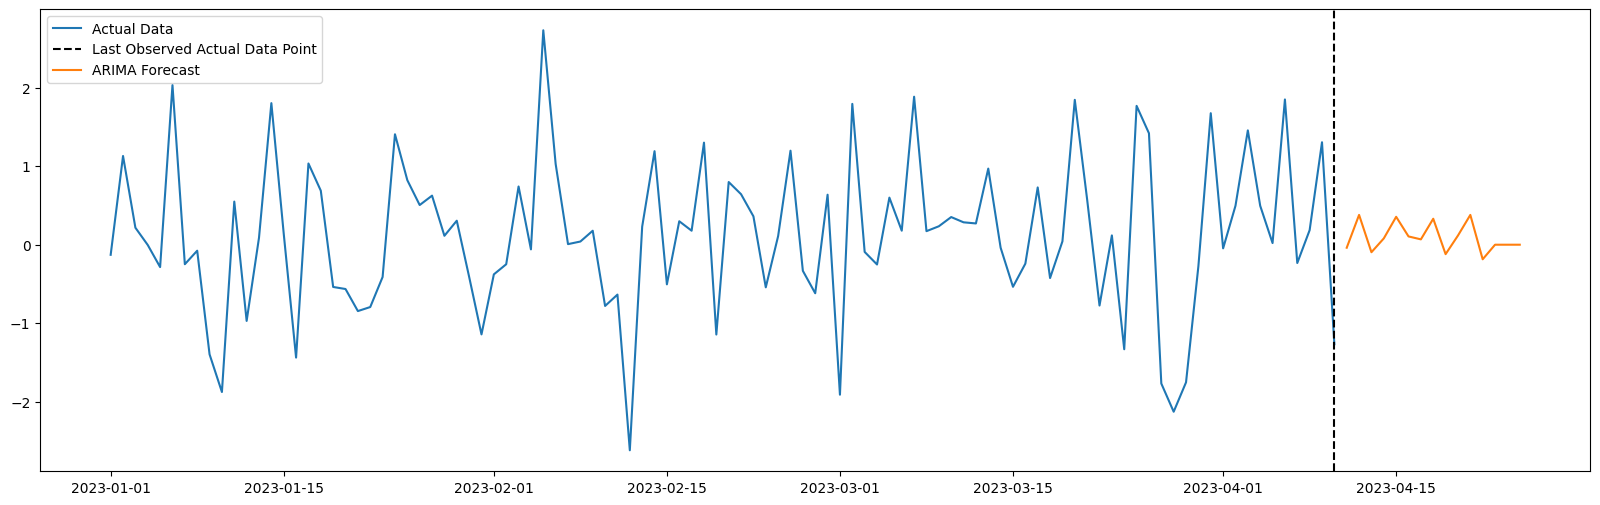

The predicted/forecast for:  2023-04-10 00:00:00  is:  0.0


In [9]:
# Forecast
plt.figure(figsize=(20, 6)) 
plt.plot(series, label='Actual Data')
# Adding a vertical line at the last date of the original series (series.index[-1])
plt.axvline(x=series.index[-1], color='black', linestyle='--', label='Last Observed Actual Data Point')
#plt.plot(reconstructed_series, label='Actual Series with Forecast')

if day ==1 :
    plt.plot(pd.date_range(start=series.index[-1] + pd.Timedelta(days=1), periods=forecast_period, freq='D'), forecast_arima_result, label='ARIMA Forecast')
elif day == 31:
    plt.plot(pd.date_range(start=series.index[-1] + pd.Timedelta(days=31), periods=forecast_period, freq='M'), forecast_arima_result, label='ARIMA Forecast')

#plt.plot(pd.date_range(start=series.index[-1] + pd.Timedelta(days=1), periods=forecast_period, freq='D'), forecast_arima_result, label='ARIMA Forecast')
plt.legend()
plt.show()

#print("The predicted/forecast for: ",reconstructed_series.index[-1], " is: ",reconstructed_series.iloc[-1])
print("The predicted/forecast for: ",series.index[-1]," is: ", forecast_arima_result.iloc[-1])

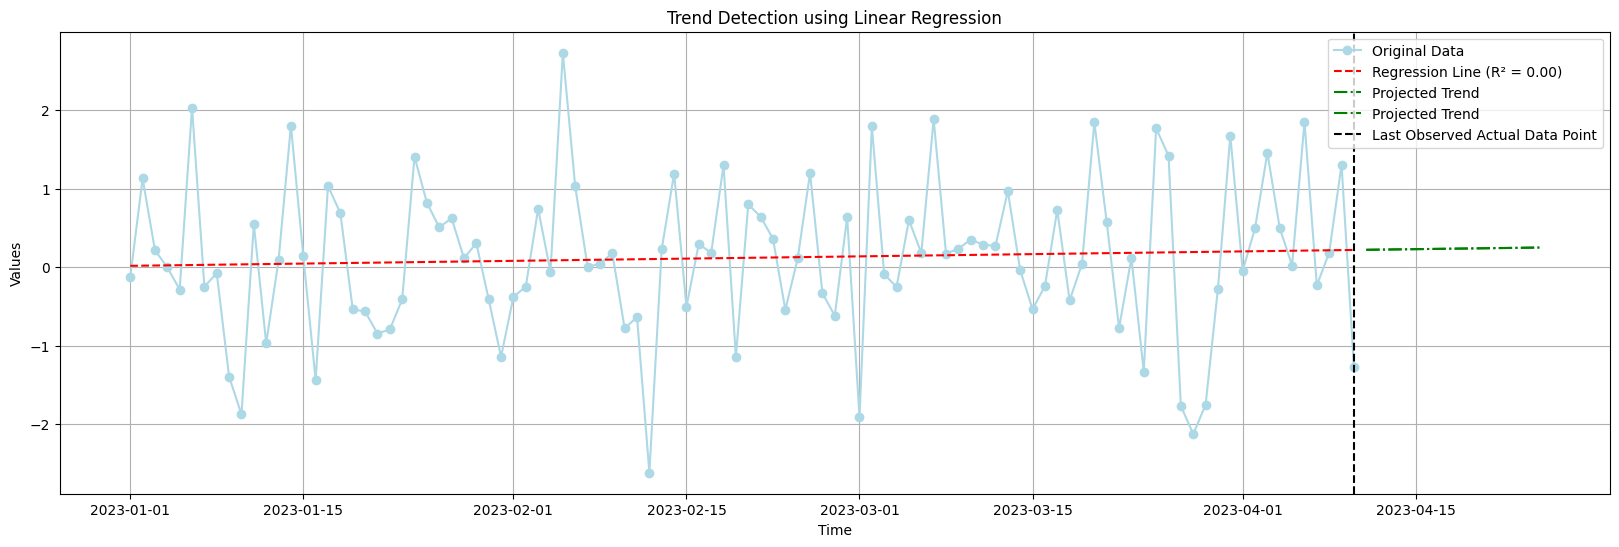

R² (R-squared): 0.00
Mean Absolute Error (MAE): 0.75
Mean Squared Error (MSE): 0.98
Root Mean Squared Error (RMSE): 0.99
The predicted/forecast for:  2023-04-10 00:00:00  is:  0.2210158194175631
No significant trend detected.


In [10]:
# Detect Trend
r2,_,_,_ = detect_trend(series, True,forecast_period)
#r2,_,_,_ = detect_trend_with_stl(series, True,forecast_period)
if r2 < 0.05:
    print("No significant trend detected.")
else:
    print("Trend detected. R-Squared value is: ",r2)

In [11]:
# Recommend Right Size
if r2 >= 0.05:
    print("It is hard to recommend a right size as the data has a definite trend.")
else:
    print("Here are the recommended Values. This of course assumes that current workload or underlying conditions does not change:")
    results = quantify_high_usage_percentile(series, percentile=85, min_duration=30) 

Here are the recommended Values. This of course assumes that current workload or underlying conditions does not change:
--------
num_periods where threshold has been exceeded  :  14
total_high_usage_time_seconds  :  1296000.0
avg_high_usage_time_seconds  :  92571.42857142857
prolonged_periods_count  :  1
start period:  2023-03-25 00:00:00  end period:  2023-03-26 00:00:00
percentile_set  :  85
metric threshold value  :  1.1917236198133674
metric max value  :  2.730191053648169
